# Single Amino Acid Classifier

In [2]:
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from IPython.display import HTML, display
from torch.nn.utils.rnn import pad_sequence

In [3]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

In [4]:
dev

'cpu'

In [5]:
torch.manual_seed(42)

In [6]:
HTML("""
<style>
table, th, td {
  border: 1px solid black;
}
</style>
""")

## Load the data

In [7]:
from google.colab import drive
from pathlib import Path


drive.mount('content/', force_remount=True)
base = Path('/content/content/My Drive/')

ModuleNotFoundError: No module named 'google.colab'

In [8]:
# Google drive
#file_paths = Path('/content/content/MyDrive/subcellular-location/v2/')

# Linux path
file_paths = Path('/home/mees/Desktop/Machine_Learning/subcellular_location/')

In [9]:
data_file = Path('data/processed/protein_data_2021-04-04.csv')
data_file = file_paths / data_file
df = pd.read_csv(data_file, sep=';')
df.head()

,Sequence,Subcellular location [CC],Location
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,"SUBCELLULAR LOCATION: Cytoplasmic vesicle, sec...",Cytoplasm
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,Endosome
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,"SUBCELLULAR LOCATION: Cytoplasm, cytoskeleton,...",Cytoplasm
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,SUBCELLULAR LOCATION: Mitochondrion {ECO:00003...,Mitochondrion
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,Cell membrane


In [10]:
df.drop(columns=['Subcellular location [CC]'], inplace=True)
df.head()

,Sequence,Location
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,Cytoplasm
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,Endosome
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,Cytoplasm
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,Mitochondrion
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,Cell membrane


### Tokenize the data

In [11]:
def create_vocab(df, protein_seqs_column, kmer_sz, stride=1, eos_token=True):
    kmers = set()
        
    # Map kmers for one-hot encoding
    kmer_to_id = dict()
    id_to_kmer = dict()

    # Loop over the protein sequences
    for protein_seq in df[protein_seqs_column]:
        # Loop over the sequence and add the amino acid if it is not in kmers set.
        seq_len = len(protein_seq)


        for i in range(0, seq_len - (kmer_sz - 1), stride):

            kmer = protein_seq[i: i + kmer_sz]

            if kmer not in list(kmers):
                ind = len(kmers)
                kmers.add(kmer)

                # Also create the dictionary
                kmer_to_id[kmer] = ind
                id_to_kmer[ind] = kmer

    if eos_token:
        token = '<EOS>'
        ind = len(kmers)
        
        kmers.add(token)

        # Also create the dictionary
        kmer_to_id[token] = ind
        id_to_kmer[ind] = token

    vocab_sz = len(kmers)

    assert vocab_sz == len(kmer_to_id.keys())
    
    return kmer_to_id, id_to_kmer, vocab_sz

In [12]:
def tokenize(df, protein_seqs_column, kmer_sz, stride=1, eos_token=True, premade_vocab=False):
    
    
    # Create the vocabulary
    if not premade_vocab:
        
        kmer_to_id, id_to_kmer, vocab_sz = create_vocab(df, protein_seqs_column, kmer_sz, stride, eos_token)
                
    else:
        kmer_to_id, id_to_kmer = premade_vocab
        vocab_sz = len(kmer_to_id.keys())
            
    # Tokenize the sequences in the DF

    tokenized = []
    for i, protein_seq in enumerate(df[protein_seqs_column], 0):
        sequence = []
        
        # If the kmer can't be found these indexes should be deleted
        remove_idxs = []
        
        # Loop over the protein sequence
        for i in  range(len(protein_seq) - (kmer_sz -1)):
            # Convert kmer to integer
            kmer = protein_seq[i: i + kmer_sz]
            
            # For some reason, some kmers miss. Thus these sequences have to be removed
            try:
                sequence.append(kmer_to_id[kmer])
            except:
                remove_idxs.append(i)
                
        if eos_token:
            sequence.append(kmer_to_id['<EOS>'])
            
        tokenized.append(sequence)
            
    df['tokenized_seqs'] = tokenized
    
    df.drop(remove_idxs, inplace=True)
    
    return df, vocab_sz, kmer_to_id, id_to_kmer

In [13]:
KMER_SIZE = 1 # Single Amino Acids

In [14]:
# Load the vocabolary from the Language Model
vocab_save_file = Path('data/interim/AA_vocab.pkl')
vocab_save_file = file_paths / vocab_save_file
vocab = pickle.load(open(vocab_save_file, 'rb'))

In [15]:
# Tokenize the protein sequence
df, vocab_sz, kmer_to_id, id_to_kmer = tokenize(df, 'Sequence', KMER_SIZE, premade_vocab=vocab)

In [16]:
df.head()

,Sequence,Location,tokenized_seqs
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,Cytoplasm,"[0, 3, 17, 3, 5, 6, 14, 1, 14, 14, 1, 18, 8, 0..."
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,Endosome,"[0, 17, 3, 17, 14, 10, 18, 14, 19, 2, 14, 14, ..."
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,Cytoplasm,"[0, 12, 17, 14, 3, 14, 9, 13, 10, 12, 13, 12, ..."
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,Mitochondrion,"[0, 4, 2, 9, 16, 4, 18, 4, 18, 16, 8, 4, 4, 4,..."
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,Cell membrane,"[0, 4, 2, 2, 5, 17, 18, 5, 18, 16, 19, 8, 18, ..."


In [17]:
len(df)

16614

### Numericalize the labelled data

In [18]:
# Some fields are NaN, remove these
df.dropna(inplace=True)
len(df)

16614

In [19]:
label_dict = {}

for i, label in enumerate(df['Location'].unique(), 0):
    label_dict[label] = i

In [20]:
def numericalizeClass(df, class_column, label_dict, label_column='Label'):
    df[label_column] = df[class_column].map(label_dict)
        
    return df

In [21]:
df = numericalizeClass(df, 'Location', label_dict)
df.head()

,Sequence,Location,tokenized_seqs,Label
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,Cytoplasm,"[0, 3, 17, 3, 5, 6, 14, 1, 14, 14, 1, 18, 8, 0...",0
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,Endosome,"[0, 17, 3, 17, 14, 10, 18, 14, 19, 2, 14, 14, ...",1
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,Cytoplasm,"[0, 12, 17, 14, 3, 14, 9, 13, 10, 12, 13, 12, ...",0
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,Mitochondrion,"[0, 4, 2, 9, 16, 4, 18, 4, 18, 16, 8, 4, 4, 4,...",2
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,Cell membrane,"[0, 4, 2, 2, 5, 17, 18, 5, 18, 16, 19, 8, 18, ...",3


In [22]:
label_dict

{'Cytoplasm': 0,
 'Endosome': 1,
 'Mitochondrion': 2,
 'Cell membrane': 3,
 'Nucleus': 4,
 'Endoplasmic reticulum': 5,
 'Secreted': 6,
 'Golgi apparatus': 7,
 'Extracellular': 8,
 'Peroxisome': 9,
 'Lysosome/ Vacuole': 10}

(array([3647.,   95.,  858., 3993., 5462.,  651., 1079.,  316.,  375.,
         138.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

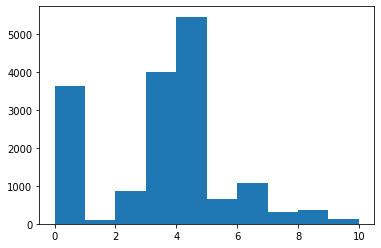

In [23]:
plt.hist(df['Label'])

(array([  3.,  19.,  16.,   5.,  13.,  30.,  40.,  82.,  99., 163.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

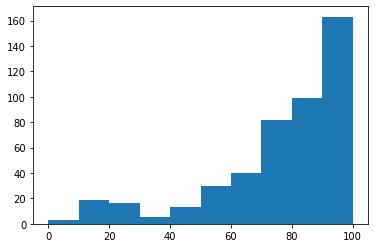

In [24]:
df['Length'] = df['tokenized_seqs'].str.len()
plt.hist(df['Length'], range=(0, 100))

In [25]:
df = df[df['Length'] > 20]
len(df)

16592

This only removed about 60 entries.
Now, to address class imbalance. Create a weighted sampler. However, the current weight labels are not correct. For each entry there should be a weight attached.

Unfortunately, adding weight labeling to the cross entropy loss doesn't work. So, for each label we are selecteing 100 randomly.

In [26]:
total_of_labels = dict(df['Label'].value_counts(sort=False))

weight_labels = []

print(total_of_labels)

for total_of_label in total_of_labels.values():
    weight = 1 / (total_of_label / len(df))
    weight_labels.append(weight)
    
weight_labels

{0: 3647, 1: 95, 2: 858, 3: 3972, 4: 5462, 5: 651, 6: 1078, 7: 316, 8: 375, 9: 53, 10: 85}


[4.5494927337537705,
 174.6526315789474,
 19.337995337995338,
 4.177240684793555,
 3.0377151226656904,
 25.48694316436252,
 15.391465677179962,
 52.506329113924046,
 44.245333333333335,
 313.05660377358487,
 195.20000000000002]

## Dataset class

In [27]:
class AminoClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, df, num_classes, bs=1):
        self.df = df
        self.num_classes = num_classes 
        self.batch_sz = bs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x = torch.LongTensor(self.df.iloc[idx]['tokenized_seqs'])
        x = x.to(dev) 
        
        y = torch.LongTensor([self.df.iloc[idx]['Label']])
        y = y.to(dev)
    
        return x, y

## The classifier

Creating the complete classifier from its different parts.

### AWD-LSTM

We start with the encoding, the AWD-LSTM as was used to train the language model. 

In [28]:
class EmbeddingDropout(torch.nn.Module):
    "Apply dropout to an Embedding with probability emp_p"

    def __init__(self, emb_p=0):
        super(EmbeddingDropout, self).__init__()
        
        self.emb_p = emb_p

    def forward(self, inp):

        bs, sl = inp.shape[:2]
        
        drop = torch.nn.Dropout(self.emb_p)
        placeholder = torch.ones((bs, sl, 1)).to(dev)
        mask = drop(placeholder)      
        out = inp * mask

        return out

In [136]:
class AWD_LSTM(torch.nn.Module):
    def __init__(self, num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, embed_p, input_p, weight_p, batch_sz = 1, pad_token=False):
        super(AWD_LSTM, self).__init__()
        
        if pad_token:
            print(vocab_sz)
            vocab_sz += 1
        
        # Embedding with dropout
        self.encoder = nn.Embedding(vocab_sz, emb_dim)
        self.emb_drop = EmbeddingDropout(emb_p=embed_p)

        
        # Dropouts on the inputs and the hidden layers
        self.hid_dp = torch.nn.Dropout(p=hidden_p)
        
        self.lstms = nn.LSTM(emb_dim, hid_sz, num_layers, batch_first = True, dropout=input_p)

        
        # Save all variables        
        self.num_layers = num_layers
        self.vocab_sz = vocab_sz
        self.emb_dim = emb_dim
        self.hid_sz = hid_sz
        self.hidden_p = hidden_p
        self.embed_p = embed_p
        self.input_p = input_p
        self.weight_p = weight_p
        self.batch_sz = batch_sz

        # Initialize hidden layers        
        self.reset_hidden()
        self.last_hiddens = (self.hidden_state, self.cell_state)
                
    def forward(self, xs):
        """Forward pass AWD-LSTM""" 
        
        bs, sl = xs.shape

        ys = []
        
        hidden_states = []
        
        hiddens = self.last_hiddens
        

        embed = self.encoder(xs)
        embed_dp = self.emb_drop(embed)

        
        inp = embed_dp.view(bs, sl, -1)
        
        # Dropout on hidden layers
        hiddens_dp = []
        for hidden_state in hiddens:
            hiddens_dp.append(self.hid_dp(hidden_state))
            
        hiddens_dp = tuple(hiddens_dp)
        
        output, (h, c) = self.lstms(embed_dp.view(bs, sl, -1), hiddens_dp)
        
        self.last_hiddens = (h.detach(), c.detach())
        
        return output, self.last_hiddens
    
    def reset_hidden(self):
        self.hidden_state = torch.zeros((self.num_layers, self.batch_sz, self.hid_sz)).to(dev)
        self.cell_state = torch.zeros((self.num_layers, self.batch_sz, self.hid_sz)).to(dev)
        self.last_hiddens = (self.hidden_state, self.cell_state)
    
    def freeze_to(self , n):
        
        params_to_freeze = n * 4 + 1 # Since each LSTM layer has 4 parameters plus 1 to also freeze the encoder
        
        total_params = len(list(self.parameters()))
        
        for i, parameter in enumerate(self.parameters()):
            parameter.requires_grad = True
            
            if i < params_to_freeze:
                parameter.requires_grad = False
            
            
        for name, parameter in self.named_parameters():
            print(name)
            print(parameter.requires_grad)

In [137]:
class AALM(nn.Module):
    def __init__(self, num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, embed_p, input_p, weight_p, batch_sz = 1, pad_token=False):
        super(AALM, self).__init__()
        
        self.encoder = AWD_LSTM(num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, 
                                embed_p, input_p, weight_p, batch_sz=batch_sz)
        self.decoder = nn.Linear(hid_sz, vocab_sz)
        
    def forward(self, inp):
        
        encoded = self.encoder(inp)
        
        y = self.decoder(encoded)
        
        return y 
    
    def freeze_to(self, n):
        self.encoder.freeze_to(n)
        
    def reset_hidden(self):
        self.encoder.reset_hidden()

## SentenceEncoder

This part encodes the whole sequence in seq_lengths using the pretrained AWD-LSTM language model.

We use the Identity class to replace the decoder in the original AWD-LSTM. 

The AWD-LSTM should not be trained, therefore, it is in between torch.no_grad()

In [138]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [139]:
class SentenceEncoder(torch.nn.Module):
    
    def __init__(self, seq_len, model, pad_token):
        super(SentenceEncoder, self).__init__()
        
        self.seq_len = seq_len
        self.model = model
        self.pad_token = pad_token
        
    def forward(self, inp):
        
        with torch.no_grad():      
            
            # First element is batch size, second element is the sequence
            inp_size = inp.shape[1]
            bs = inp.shape[0]
            
            # Padded parts should not be taken into account and these padded sequences cannot go trough the embedding
            padded = inp == self.pad_token
            
            # It is nicer to add padding
            max_iterations = int(inp_size / self.seq_len)

            hidden_state_outputs = []
            cell_state_outputs = []
            
            # Save masked output for the pooling calculations
            masked_outputs = []
            corr_size = 0
            
            for i in range(0, self.seq_len * max_iterations, self.seq_len):

                # Calculate the corrected batch size, meaning that a sequence only consisting of 
                # the padding_token will be not put in the LSTM
                total_padded = padded[:,i : i + self.seq_len].sum(dim = 1) > 0
                corr_bs = (total_padded == False).sum()
                
                _, hidden = self.model(inp[:corr_bs, i: i + self.seq_len])
                
                print(hidden[0].shape)
                break
                
                for states in hidden:
                    hidden_state_output = states[0]
                    cell_state_output = states[1]

                    # In order to concate the hidden outputs we have to correct for the decrease in batch size
                    if corr_bs != bs:
                        corr_size = bs - corr_bs
                        corr_hidden = torch.zeros(1, corr_size, hidden_state_output.shape[2])
                        corr_mask = torch.zeros(1, corr_size)
                        
                        hidden_state_output = torch.cat([hidden_state_output, corr_hidden], dim = 1)
                        cell_state_output = torch.cat([cell_state_output, corr_hidden], dim = 1) 
                    
                    
                    # If no corrections for sequence length is made the mask will be one (there is no mask)
                    if corr_size == 0:
                        mask = torch.ones(1, bs)
                    # If there are corrections made, mask will be a combination of ones for the sequence in the batch
                    # that is not corrected and zeros for the sequence that is corrected 
                    else:
                        unmasked = bs - corr_size
                        mask = torch.ones(1, unmasked)
                        
                        mask = torch.cat([mask, corr_mask], dim = 1)
                        
                        
                    masked_outputs.append(mask)
                    hidden_state_outputs.append(hidden_state_output)
                    cell_state_outputs.append(cell_state_output)
                
                   
            hidden_state_outputs = torch.cat(hidden_state_outputs, dim = 0)
            cell_state_outputs = torch.cat(cell_state_outputs, dim = 0)
            masked_outputs = torch.cat(masked_outputs, dim = 0)

            return (hidden_state_outputs, cell_state_outputs), masked_outputs

## PoolingLinearClassifier

The encoded sequence is needed to be pooled, otherwise the model can not use the information for classification.

Then, the data is normalized using batchnorm. Dropout is applied to prevent overfitting. And linear layers with a ReLU activiation are used to classify the pooled protein data.


In [140]:
def pool_encoded_sequence(output, masked):
    r"""Pool the encoded AA sequence and 
    return one vector with the max_pool and avg_pool concatenated"""
    
    hidden_states = output[0]
    #cell_states = output[1]
    
    mask = masked == 0
    
    sl, bs = hidden_states.shape[:2]
    
    
    lens = hidden_states.shape[0] - mask.long().sum(dim = 0)
    last_lens = mask[-sl:,:].long().sum(dim = 0).max() - 1

    last_hidden_state = hidden_states[-last_lens, :, :]
    #last_cell_state = cell_states[-1, :, :]
    
    hidden_state_avg = hidden_states.masked_fill_(mask[:, :, None], 0).sum(dim = 0)
    hidden_state_avg.div_(lens[:, None])
    #cell_state_avg = cell_states.sum(dim=0) / sl
    

    hidden_state_max = hidden_states.masked_fill_(mask[:, :, None], -float('inf')).max(dim = 0)[0]
    #cell_state_max = hidden_states.max(dim=0)[0]

    #x = torch.cat([last_hidden_state, last_cell_state, hidden_state_avg, cell_state_avg, \
    #              hidden_state_max, cell_state_max], 0)

    x = torch.cat([last_hidden_state, hidden_state_avg, hidden_state_max], 1)
    
    x = x.view(bs, -1)
    
    return x

In [141]:
class PoolingLinearClassifier(torch.nn.Module):
    r"""Pool the outputs from the encoder and classify it."""
    
    def __init__(self, num_classes, batch_sz):
        super(PoolingLinearClassifier, self).__init__()
        
        self.num_classes = num_classes
        self.batch_sz = batch_sz
        
        if batch_sz > 1:
            
            self.layers = nn.Sequential(
                nn.BatchNorm1d(1150 * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.2, inplace=False),
                nn.Linear(in_features=1150 * 3, out_features=50, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.1, inplace=False),
                nn.Linear(in_features=50, out_features=num_classes, bias=True)
            )
        else:
            self.layers = nn.Sequential(
                nn.Dropout(p=0.2, inplace=False),
                nn.Linear(in_features=1150 * 3, out_features=50, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1, inplace=False),
                nn.Linear(in_features=50, out_features=num_classes, bias=True)
            )
            
        
    
    def forward(self, inp):
        output_encoder, padded = inp
        pooled_output = pool_encoded_sequence(output_encoder, padded)
        y = self.layers(pooled_output)
        
        return y        

In [142]:
num_classes = len(label_dict)
num_classes

11

## Combine everything in the protein classifier

In [143]:
class proteinClassifier(torch.nn.Module):
    r"""The complete protein classifier"""
    
    def __init__(self, num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, embed_p, input_p, weight_p, seq_len, num_classes, batch_size, pretrained_file=False):
        super(proteinClassifier, self).__init__()
        
        self.num_layers = num_layers
        self.vocab_sz = vocab_sz
        self.emb_dim = emb_dim
        self.hid_sz = hid_sz
        self.hidden_p = hidden_p
        self.embed_p = embed_p
        self.input_p = input_p
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.batch_size = batch_size
        
        pad_token = vocab_sz
        
        if pad_token:
        
            language_model = AALM(num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, 
                                  embed_p, input_p, weight_p, batch_sz=batch_size, pad_token=True)

        else:
            language_model = AALM(num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, 
                                      embed_p, input_p, weight_p, batch_sz=batch_size)
        
        if pretrained_file:
            language_mode = torch.load(pretrained_file, map_location=torch.device(dev))
        
        language_model.decoder = Identity()
        
        encoder = SentenceEncoder(seq_len, language_model, pad_token)
        
        classifier = PoolingLinearClassifier(num_classes, self.batch_size)
        
        self.layers = nn.Sequential(encoder, classifier)
        
    def forward(self, inp):
        y = self.layers(inp)
        return y

## Model hyperparameters and train the data

In [144]:
# Hyperparameters
emb_dim = 10 # Embeddding dimension
hid_sz = 1150 # Hidden size
num_layers = 20 # Number of LSTM layers stacked together
seq_len = num_layers # Based on paper mentioned above
batch_size = 2 

# Dropout parameters

embed_p = 0.1 # Dropout probability on the embedding
hidden_p = 0.3 # Dropout probability on hidden-to-hidden weight matrices
input_p = 0.3 # Dropout probablity on the LSTM input between LSTMS
weight_p = 0.5 # Dropout probability on LSTM-to-LSTM weight matrices

## Load the pretrained model

In [145]:
pretrained_model = Path('models/1.27_percent_single_AA_v2.pt')
pretrained_model = file_paths / pretrained_model

In [146]:
model = proteinClassifier(num_layers, vocab_sz, emb_dim, hid_sz, hidden_p,
                         embed_p, input_p, weight_p, seq_len, num_classes, batch_size, pretrained_model)
model.to(dev)

proteinClassifier(
  (layers): Sequential(
    (0): SentenceEncoder(
      (model): AALM(
        (encoder): AWD_LSTM(
          (encoder): Embedding(26, 10)
          (emb_drop): EmbeddingDropout()
          (hid_dp): Dropout(p=0.3, inplace=False)
          (lstms): LSTM(10, 1150, num_layers=20, batch_first=True, dropout=0.3)
        )
        (decoder): Identity()
      )
    )
    (1): PoolingLinearClassifier(
      (layers): Sequential(
        (0): BatchNorm1d(3450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=3450, out_features=50, bias=True)
        (3): ReLU(inplace=True)
        (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Dropout(p=0.1, inplace=False)
        (6): Linear(in_features=50, out_features=11, bias=True)
      )
    )
  )
)

## Learning hyperparameters

In [147]:
# Hyperparameters
learning_rate = 0.001
epochs = 5
adam_betas = (0.7, 0.99)

In [148]:
# Costfunction and optimize algorithm
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_labels))
#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=adam_betas)

## Train the model

Since the data has different length, therefore I use the pack_sequence in the collate fn.
https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/12

In [149]:
# Deze functie voegt padding toe zodat ik een batch kan runnen want een batch moet gelijke grote hebben.
# En sorteert ook op grote

def collate_fn_padd(batch):
    
    padding_value = vocab_sz

    seqs = []
    ys = []
    
    for seq in batch:
        seqs.append(seq[0])
        ys.append(seq[1])

    # Add padding to the sequences
    padded = pad_sequence(seqs, batch_first=True, padding_value=padding_value)
    
    ys = torch.stack(ys, dim=0)
    
    
    # Calculate the real size so that the padded sequences can be sorted
    masked = padded == padding_value    
    real_seq_size = padded.size(1) - masked.sum(dim=1)
    _, indices = torch.sort(real_seq_size, descending=True)
    
    sorted_masked = torch.zeros_like(masked)
    sorted_padded_sequences = torch.zeros_like(padded)
    
    for i, ind in enumerate(indices, 0):
        sorted_padded_sequences[i] = padded[ind]
        sorted_masked[i] = masked[ind]
    
    """ 
    # It is nicer to add padding
    max_iterations = int(sorted_padded_sequences.size(1) / 50)
    
    
    # Testen hoe ik uit kan vogelen hoe die batch sizes kunnen worden aangepast
    for i in range(0, max_iterations * 50, 50):
        print('Possible input')
        inp = sorted_padded_sequences[:, i:i + 50]
        total_mask = sorted_masked[:, i:i+50].sum(dim=1) == 50
        true_bs = (total_mask == False).sum()
        print(total_mask)
        print(true_bs)
    """ 
    
    return sorted_padded_sequences, ys   

In [150]:
# Load the data in the DataSet
AADataset = AminoClassifierDataset(df, num_classes)

In [151]:
# Split the data in an 80/20% split for training and testing
data_len = len(AADataset)
train_part = int(0.8 * data_len)
test_part = data_len - train_part

train_set, test_set = torch.utils.data.random_split(AADataset, [train_part, test_part])


In [152]:
# Load the data into data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_padd)

In [153]:
# Test for the real work
for i, entry in enumerate(train_loader, 0):
    xs, ys = entry[0], entry[1]
    
    print(xs.shape)
    print(ys.shape)
    
    outputs = model(xs)
    
    # Flatten the label
    ys = ys.view(-1)

    print(outputs.shape)
    print(outputs)
    print(ys.shape)
    
    print(ys)
    
    loss = criterion(outputs, ys)
    print(loss)
    break

torch.Size([2, 808])
torch.Size([2, 1])
Batch size is:
2
torch.Size([20, 2, 1150])


RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradNestedTensor, UNKNOWN_TENSOR_TYPE_ID, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:5925 [kernel]
QuantizedCPU: registered at /pytorch/build/aten/src/ATen/RegisterQuantizedCPU.cpp:641 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:10525 [kernel]
Autocast: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:254 [kernel]
Batched: registered at /pytorch/aten/src/ATen/BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
